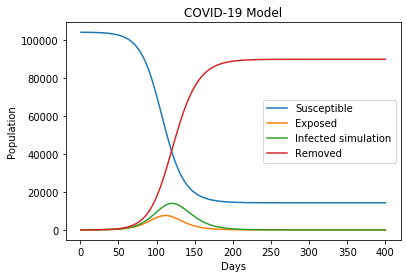

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
Comunas=34
def Runge_Kutta4_Sis(A,B,C,D,S0,E0,I0,R0,t0,T,h):
    t=np.arange(t0,T+h,h)
    S=np.zeros((Comunas,len(t)))
    E=np.zeros((Comunas,len(t)))
    I=np.zeros((Comunas,len(t)))
    R=np.zeros((Comunas,len(t)))
    S[:,0]=S0
    E[:,0]=E0
    I[:,0]=I0
    R[:,0]=R0
    for j in range(len(t)-1):
        k1A = h*A(t[j], S[:,j], I[:,j])
        k1B = h*B(t[j], S[:,j], I[:,j], E[:,j])
        k1C = h*C(t[j], E[:,j], I[:,j])
        k1D = h*D(t[j], I[:,j])
        k2A = h*A(t[j] + h/2, S[:,j] + 0.5*k1A, I[:,j] + 0.5*k1C)
        k2B = h*B(t[j] + h/2, S[:,j] + 0.5*k1A, I[:,j] + 0.5*k1C, E[:,j] + 0.5*k1B)
        k2C = h*C(t[j] + h/2, E[:,j] + 0.5*k1B, I[:,j] + 0.5*k1C)
        k2D = h*D(t[j] + h/2, I[:,j] + 0.5*k1C)      
        k3A = h*A(t[j] + h/2, S[:,j] + 0.5*k2A, I[:,j] + 0.5*k2C)
        k3B = h*B(t[j] + h/2, S[:,j] + 0.5*k2A, I[:,j] + 0.5*k2C, E[:,j] + 0.5*k2B)
        k3C = h*C(t[j] + h/2, E[:,j] + 0.5*k2B, I[:,j] + 0.5*k2C)
        k3D = h*D(t[j] + h/2, I[:,j] + 0.5*k2C)
        k4A = h*A(t[j] + h, S[:,j] + k3A, I[:,j] + k3C)
        k4B = h*B(t[j] + h, S[:,j] + k3A, I[:,j] + k3C, E[:,j] + k3B)
        k4C = h*C(t[j] + h, E[:,j] + k3B, I[:,j] + k3C)
        k4D = h*D(t[j] + h, I[:,j] + k3C)
        S[:,j+1]=S[:,j] +1/6*(k1A + 2*k2A + 2*k3A + k4A)
        E[:,j+1]=E[:,j] +1/6*(k1B + 2*k2B + 2*k3B + k4B)
        I[:,j+1]=I[:,j] +1/6*(k1C + 2*k2C + 2*k3C + k4C)
        R[:,j+1]=R[:,j] +1/6*(k1D + 2*k2D + 2*k3D + k4D)
        
    plt.figure()
    plt.plot(t,S[0,:],label='Susceptible')
    plt.plot(t,E[0,:],label='Exposed')
    plt.plot(t,I[0,:],label='Infected simulation')
    plt.plot(t,R[0,:],label='Removed')
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.title('COVID-19 Model')
    plt.legend(loc=0)
    plt.show()
        

#S0=[17500000] #17500000
#E0=[0]        #0
#I0=[1]        #1
#R0=[0]        #0
So = pd.read_excel("poblacion_Inicial_S_stgo.xlsx", header=None).to_numpy()
S0 = So[:,0]
Eo = pd.read_excel("poblacion_Inicial_E_stgo.xlsx", header=None).to_numpy() 
E0 = Eo[:,0]
Io = pd.read_excel("poblacion_Inicial_I_stgo.xlsx", header=None).to_numpy()
I0 = Io[:,0]
Ro = pd.read_excel("poblacion_Inicial_R_stgo.xlsx", header=None).to_numpy()
R0 = Ro[:,0]

#N=[1/(S0[0] + E0[0] + I0[0] + R0[0])]
n = pd.read_excel("poblacion_N_stgo.xlsx", header=None).to_numpy()
N=1/n[:,0]
#G=np.eye(Comunas,Comunas)

P = pd.read_excel("connectivity_stgo2.xlsx", header=None)
G = Matriz_Movilidad(P)

beta=0.2     #0.8
sigma=0.2   #0.4
gamma=0.1    #1/14
    
A = lambda t,S,I: -beta*np.diag(N).dot(np.diag(S)*G).dot(I);
B = lambda t,S,I,E: beta*np.diag(N).dot(np.diag(S)*G).dot(I) - sigma*E;
C = lambda t,E,I: sigma*E - gamma*I;
D = lambda t,I: gamma*I;

t0=1
T=400
h=1
Runge_Kutta4_Sis(A,B,C,D,S0,E0,I0,R0,t0,T,h)
    

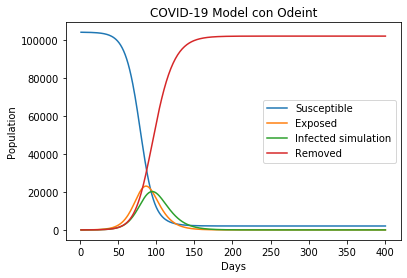

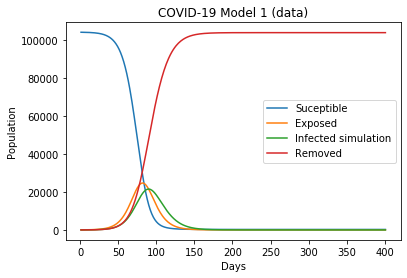

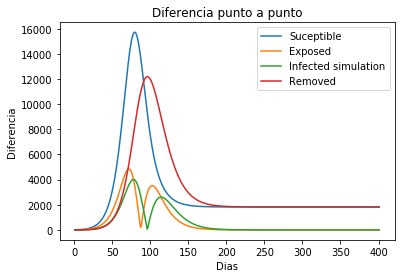

In [23]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
#Modulo matrices_movilidad contiene dos funciones para constriur G, eventualmente, ellas se podran modificar y asi modificamos G
from matrices_movilidad1 import Matriz_Movilidad
from matrices_movilidad1 import Matriz_Movilidad_alpha 
# odeint(sum_g_ij, N_i)
# Si no se considera alpha, cuarentena y k toman el valor de None
def Model(Init_Cond,t,Ni,P,cuarentena,k):
    if cuarentena and k is not None:
        if t==cuarentena:
            G=Matriz_Movilidad_alpha(P,k)
            g=sum(G[0,:])
        elif t>cuarentena:
            g=sum(G[0,:])
    else:
        G = Matriz_Movilidad(P)
        g=sum(G[0,:])
        beta=0.2
        sigma=0.1
        gamma=0.1
    
        S=Init_Cond[0]
        E=Init_Cond[1]
        I=Init_Cond[2]
        R=Init_Cond[3]
    
        dSdt=-beta*S*(1/Ni)*g*I
        dEdt=beta*S*(1/Ni)*g*I - sigma*E
        dIdt=sigma*E - gamma*I
        dRdt=gamma*I
        return [dSdt, dEdt, dIdt, dRdt]

So = pd.read_excel("poblacion_Inicial_S_stgo.xlsx", header=None).to_numpy()
S0 = So[0,0]
Eo = pd.read_excel("poblacion_Inicial_E_stgo.xlsx", header=None).to_numpy() 
E0 = Eo[0,0]
Io = pd.read_excel("poblacion_Inicial_I_stgo.xlsx", header=None).to_numpy()
I0 = Io[0,0]
Ro = pd.read_excel("poblacion_Inicial_R_stgo.xlsx", header=None).to_numpy()
R0 = Ro[0,0] 

Init_Cond=[S0,E0,I0,R0]
T=401
h=1
t=np.arange(1,T+h,h)

n = pd.read_excel("poblacion_N_stgo.xlsx", header=None).to_numpy()
Ni=n[0,0]

P = pd.read_excel("connectivity_stgo2.xlsx", header=None)
SEIR=odeint(Model,Init_Cond,t, args=(Ni,P,None,None))

S=SEIR[:,0]
E=SEIR[:,1]
I=SEIR[:,2]
R=SEIR[:,3]

plt.figure()
plt.plot(t,S,label='Susceptible')
plt.plot(t,E,label='Exposed')
plt.plot(t,I,label='Infected simulation')
plt.plot(t,R,label='Removed')
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('COVID-19 Model con Odeint')
plt.legend(loc=0)
plt.show()   

#### Grafico de datos alejandro
S_su1 = pd.read_excel("Simulacion-400dias-S.xlsx", header=None).to_numpy()
E_su1 = pd.read_excel("Simulacion-400dias-E.xlsx", header=None).to_numpy()
I_su1 = pd.read_excel("Simulacion-400dias-I.xlsx", header=None).to_numpy()
R_su1 = pd.read_excel("Simulacion-400dias-R.xlsx", header=None).to_numpy()
plt.figure()
plt.plot(t,S_su1[0,:],label='Suceptible')
plt.plot(t,E_su1[0,:],label='Exposed')
plt.plot(t,I_su1[0,:],label='Infected simulation')
plt.plot(t,R_su1[0,:],label='Removed')
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('COVID-19 Model 1 (data)')
plt.legend(loc=0)
plt.show() 

### Grafico de diferencias punto a punto.

dif_S=np.abs(S-S_su1[0,:])
dif_E=np.abs(E-E_su1[0,:])
dif_I=np.abs(I-I_su1[0,:])
dif_R=np.abs(R-R_su1[0,:])

plt.figure()
plt.plot(t,dif_S,label='Suceptible')
plt.plot(t,dif_E,label='Exposed')
plt.plot(t,dif_I,label='Infected simulation')
plt.plot(t,dif_R,label='Removed')
plt.xlabel('Dias')
plt.ylabel('Diferencia')
plt.title('Diferencia punto a punto')
plt.legend(loc=0)
plt.show()
